# Building the Arabidopsis C3 and Maize C4 models

## Imports

In [1]:
import pandas as pd
from cobra.io import read_sbml_model, write_sbml_model
from cobra import flux_analysis, Reaction
from model_functions import *
#General Core Model
general_model = read_sbml_model("PlantCoreMetabolism_v2_0_0_deprotonated.sbml")

In [2]:
general_model

Name,PlantCoreMetabolism_v1_3_0
Memory address,0x0277e3bca3c8
Number of metabolites,861
Number of reactions,892
Number of groups,208
Objective expression,1.0*Phloem_output_tx - 1.0*Phloem_output_tx_reverse_990b1
Compartments,"Mitochondrion, Cytoplasm, Biomass, Plastid, Vacuole, Peroxisome, Endoplasmic reticulum, Mitochondrion innermembrane interacting with cristal space, Mitochondrion innermembrane interacting with inter membrane space, Extracellular, Thylakoid, Mitochondrial intermembrane space"


In [3]:
print(general_model.compartments)

{'m': 'Mitochondrion', 'c': 'Cytoplasm', 'b': 'Biomass', 'p': 'Plastid', 'v': 'Vacuole', 'x': 'Peroxisome', 'r': 'Endoplasmic reticulum', 'mi': 'Mitochondrion innermembrane interacting with cristal space', 'mc': 'Mitochondrion innermembrane interacting with inter membrane space', 'e': 'Extracellular', 'l': 'Thylakoid', 'i': 'Mitochondrial intermembrane space'}


## Adding reactions
### Biomass equations and Malate/Pyruvate transporter

In [4]:
"""
Maize Biomass
"""
#Create the biomass reaction
reaction = Reaction('Maize_biomass_tx')
reaction.name = 'Maize biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:,"Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:,"Maize"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]:coef[i]})
    
#Add reaction to the model
general_model.add_reactions([reaction])

In [5]:
"""
Arabidopsis biomass
"""

reaction = Reaction('Arabidopsis_biomass_tx')
reaction.name = 'Arabidopsis biomass'
reaction.lower_bound = 0.  # This is the default
reaction.upper_bound = 1000.  # This is the default

#Import the pandas dataframe
df = pd.read_csv("Final_Biomass_V1.csv")

#Get a list with the metabolite IDs from the generic model
met_list = []

for id in df.loc[:,"Ids"]:
    met = general_model.metabolites.get_by_id(id)
    met_list.append(met)

#Create a list with the coefficients
coef = list(df.loc[:,"Arabidopsis"])

#Add metabolites to the model: dictionary - keys are metabolites and values are the coefficients
for i in range(len(coef)):
    reaction.add_metabolites({met_list[i]:coef[i]})

#Add reaction to the model
general_model.add_reactions([reaction])

In [6]:
"""
Malate/Pyruvate Transporter
"""
#Adding Malate/Pyruvate transporter between the cytosol and plastid compartments

MAL_c = general_model.metabolites.MAL_c
MAL_p = general_model.metabolites.MAL_p
PYRUVATE_c = general_model.metabolites.PYRUVATE_c
PYRUVATE_p = general_model.metabolites.PYRUVATE_p

#Create the biomass reaction
transporter = Reaction('PYR_MAL_pc')
transporter.name = 'Malate/Pyruvate Transport'
transporter.lower_bound = -1000.  # This is the default
transporter.upper_bound = 1000.

transporter.add_metabolites({
    PYRUVATE_p: -1.0,
    MAL_c: -1.0,
    PYRUVATE_c: 1.0,
    MAL_p: 1.0
})

general_model.add_reactions([transporter])


## Adding Constrains to both C3 and C4 models

In [7]:
"""
Generic constrains
"""
#Initial import/export constraints - Defining autotrofic conditions
set_bounds('CO2_tx', (-9999999, 999999), general_model)
set_bounds('H2O_tx', (-9999999, 999999), general_model)
set_bounds('NH4_tx', (0., 0.), general_model) # Stop Ammonium import
set_bounds('Pi_tx', (0, 999999), general_model)
set_bounds('SO4_tx', (0, 9999999), general_model)
set_bounds('O2_tx', (-999999, 999999), general_model)
set_bounds('Sucrose_tx', (-999999, 0), general_model) #Exported but not imported
set_bounds('GLC_tx', (-999999, 0), general_model)

#Bounds for ATP
set_bounds('ATPase_tx', (0, 999999), general_model)

#Bounds for chloroplastic NADPH dehydrogenase and plastoquinol oxidase
#set_bounds('ISOCITDEH_RXN_c', (0, 0), general_model) #The only equivalent for the reaction in the Blaetke pipeline is in the cytosol
set_bounds('Plastoquinol_Oxidase_p', (0, 0), general_model)

#NTT is only active at night
set_fixed_flux("ATP_ADP_Pi_pc", 0, general_model)

## Building the C4 model

In [8]:
"""
Creating the C4 model
"""

from cobra import Model, Reaction, Metabolite

c4_model = Model('c4_model')

cell_types = ['M', 'B']

#duplicate metabolites
for m in general_model.metabolites:
    for cell in cell_types:
        m_dt = Metabolite('['+cell+']_'+m.id, name = m.formula, compartment = m.compartment)
        c4_model.add_metabolites([m_dt])

#duplicate reactions
for r_c3_obj in general_model.reactions:
    for cell in cell_types:
        r_c4_obj = Reaction('['+cell+']_'+r_c3_obj.id)
        r_c4_obj.name = r_c3_obj.name
        r_c4_obj.subsystem = r_c3_obj.subsystem
        r_c4_obj.bounds = r_c3_obj.bounds
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'['+cell+']_'+m_c3_obj.id: r_c3_obj.get_coefficient(m_c3_obj) for m_c3_obj in r_c3_obj.metabolites})



In [9]:
"""
Exchange Reactions

All metabolites except Na, AD, DHF, TRXox, TRXrd, T6P and OMP have
corresponding metabolites in the plastid compartment of the generic model

"""

Na,F26BP, ORO, DHO, GABA, PRPP, AD, DHF, starch, TRXox, TRXrd, T6P, OMP, UMP, CTP, dADP, dCDP, dGDP, dUDP, dATP, dCTP, dGTP = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


no_transport_general = ['NITRATE', "NITRITE", "OXYGEN_MOLECULE", Na, "aHS", "SULFATE",
                        "WATER", "FRUCTOSE_16_DIPHOSPHATE",  F26BP, "DPG", "PROTON", "ACETALD", "ACET", "5_10_METHENYL_THF",
                        "5_METHYL_THF", "HOMO_CYS", "ADENOSYL_HOMO_CYS", ORO, DHO,
                        GABA, "ACETYLSERINE", PRPP, AD, "THF", DHF , "ADENOSINE", "MALTOSE", "CO_A", "L_GLUTAMATE_5_P", "aL_GLUTAMATE_5_P_c"
                        "ACETYL_COA", "CELLULOSE", starch, TRXox, TRXrd, "L_GLUTAMATE_GAMMA_SEMIALDEHYDE", T6P, "S_ADENOSYLMETHIONINE",
                        "PPI", "L_DELTA1_PYRROLINE_5_CARBOXYLATE", "AMMONIUM", "Pi", "CARBON_DIOXIDE", "OXALACETIC_ACID", "HCO3",
                        "UTP","aUTP", "UDP","aUDP", "UDP_GLUCOSE", "ATP", "aATP","ADP", "aADP","AMP", "IMP", "aIMP","XANTHOSINE_5_PHOSPHATE", "aXANTHOSINE_5_PHOSPHATE",
                        "GTP", "aGTP","GDP","aGDP", "GMP","aGMP", "bGMP",OMP, UMP, CTP, "GDP", "aGDP","CDP", dADP,
                        dCDP, dGDP, dUDP, "DUMP", "DTMP",  "aDTDP", "GTP",
                        dATP, dCTP, dGTP, "DTTP" "aDTTP", "NAD", "NADH", "NADP", "NADPH"]

#add M/BS exchange reactions
L_r_transport = []
for m_c3_obj in general_model.metabolites:
    if m_c3_obj.id[-1:] == 'c' and m_c3_obj.id[:-2] not in no_transport_general and  m_c3_obj.id[-2:] != 'mc':
        r_c4_obj = Reaction('[MB]_'+m_c3_obj.id)
        r_c4_obj.name = '[MB]_'+m_c3_obj.id
        r_c4_obj.subsystem = 'Exchange'
        r_c4_obj.bounds = (-99999999, 9999999)
        c4_model.add_reaction(r_c4_obj)
        r_c4_obj.add_metabolites({'[M]_'+m_c3_obj.id: -1,'[B]_'+m_c3_obj.id: 1 })
        L_r_transport.append('[MB]_'+m_c3_obj.id)

In [10]:
"""
C4 specific constrains
"""

#CONSTRAINT: No CO2 uptake in bundle sheat cells due to suberin layer in cell membranes
set_bounds("[B]_CO2_tx", (0.,0.), c4_model)

#Force C4 cycle: Block Rubisco carboxylase/oxygenase in Mesophyll
set_bounds('[M]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p', (0, 0), c4_model)
set_bounds('[M]_RXN_961_p', (0, 0), c4_model)

#Force NADP-ME decarboxylation pathway: Block all other decarboxylation reactions except NADP_ME in the plastid
set_fixed_flux("[B]_PEPCARBOXYKIN_RXN_c", 0, c4_model)
set_fixed_flux("[B]_1_PERIOD_1_PERIOD_1_PERIOD_39_RXN_m", 0, c4_model)
set_fixed_flux("[B]_MALIC_NADP_RXN_c", 0, c4_model)

#Force NADP-ME decarboxylation pathways: make alternative decarboxylation routes irreversible
set_bounds('[B]_CARBAMATE_KINASE_RXN_p', (0, 99999999), c4_model)
set_bounds('[M]_CARBAMATE_KINASE_RXN_p', (0, 99999999), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_m', (0, 99999999), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_m', (0, 99999999), c4_model)

set_bounds('[B]_ISOCITDEH_RXN_c', (0, 99999999), c4_model)
set_bounds('[M]_ISOCITDEH_RXN_c', (0, 99999999), c4_model)

set_bounds('[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 99999999), c4_model)
set_bounds('[M]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m', (0, 99999999), c4_model)

#Fix malate transport
set_bounds('[B]_OAA_MAL_pc', (0, 99999999), c4_model)

set_bounds('[B]_PYRUVATE_pc', (0, 0), c4_model)

set_bounds('[M]_PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c', (0, 0), c4_model)

In [11]:
"""
Write the models

"""

write_sbml_model(general_model, "c3_model.xml")
write_sbml_model(c4_model, "c4_model.xml")


## Reading the models

### Adding Rubisco and Light Dependent Maintenance constrains

In [12]:
"""
Read and prepare c3 model
"""

c3_model = read_sbml_model("c3_model.xml")

c3_model.solver = "glpk"

c3_model.objective = "Arabidopsis_biomass_tx"

#Setting up Rubisco carboxylase/oxygenase ratio in C3 model
set_fixed_flux_ratio({'RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p':3,'RXN_961_p':1},c3_model)

#Setting up Light dependent maintenace in the C3 model
def c3_maintenance(c3_model):
    #Constrains for light dependent maintenance costs
    c3_model.reactions.ATPase_tx.flux_expression
    c3_model.reactions.Photon_tx.flux_expression

    const = c3_model.problem.Constraint((0.0049 * c3_model.reactions.Photon_tx.flux_expression + 2.7852) - c3_model.reactions.ATPase_tx.flux_expression , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)
    
    # ATP/NADPH 3:1 constraints
    const = c3_model.problem.Constraint(c3_model.reactions.ATPase_tx.flux_expression - 3 *(c3_model.reactions.NADPHoxc_tx.flux_expression + c3_model.reactions.NADPHoxp_tx.flux_expression + c3_model.reactions.NADPHoxm_tx.flux_expression) , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)
    
#Add Light dependent maintenance
c3_maintenance(c3_model)

In [13]:
#Complete C3 model
c3_model

Name,PlantCoreMetabolism_v1_3_0
Memory address,0x0277e7e3b8c8
Number of metabolites,861
Number of reactions,895
Number of groups,208
Objective expression,1.0*Arabidopsis_biomass_tx - 1.0*Arabidopsis_biomass_tx_reverse_f8680
Compartments,"Mitochondrion, Cytoplasm, Biomass, Plastid, Vacuole, Peroxisome, Endoplasmic reticulum, Mitochondrion innermembrane interacting with cristal space, Mitochondrion innermembrane interacting with inter membrane space, Extracellular, Thylakoid, Mitochondrial intermembrane space"


In [14]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[B]_Maize_biomass_tx'


def c4_maintenance(c4_model):
    
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


In [15]:
#Complete C4 model
c4_model

Name,c4_model
Memory address,0x0277eb031f08
Number of metabolites,1722
Number of reactions,1981
Number of groups,0
Objective expression,1.0*[B]_Maize_biomass_tx - 1.0*[B]_Maize_biomass_tx_reverse_fd280
Compartments,"m, c, b, p, v, x, r, mi, mc, e, l, i"


### Flux Balance Analysis

In [16]:
"""
Functions to perform a FBA defining limiting constrains of either light or nitrogen uptake
"""

def c3_simulation(light, N, c3_model, mode):
    with c3_model:
        #Bounds for light
        set_bounds('Photon_tx', (0, light), c3_model)
        #Bounds for Nitrogen
        set_bounds('Nitrate_tx', (0, N), c3_model)
        #FBA
        if mode == "value":
            return c3_model.optimize().objective_value
        else:
            return c3_model.summary()
        # original: print(f'Arabidopsis C3 FBA: {c3_model.summary()}')

def c4_simulation(light, N, c4_model, mode):
    with c4_model:
        #Light Uptake constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        
        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_sum)
        
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_ratio)
        
        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        bs_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        m_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        
        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = 0, ub = N)
        c4_model.add_cons_vars(const_n_ratio)
        
        #FBA
        if mode == "value":
            return c4_model.optimize().objective_value
        else:
            return c4_model.summary()
        # original: print(f'Maize C4 FBA: {c4_model.summary()}')


In [17]:
#Running simulations
print(c3_simulation(1000, 10 , c3_model, ''))

Objective
1.0 Arabidopsis_biomass_tx = 0.10657216597369851

Uptake
------
      Metabolite      Reaction    Flux  C-Number  C-Flux
CARBON_DIOXIDE_e        CO2_tx   53.87         1 100.00%
         WATER_e        H2O_tx   46.43         0   0.00%
       NITRATE_e    Nitrate_tx      10         0   0.00%
        Photon_e     Photon_tx   894.9         0   0.00%
            Pi_e         Pi_tx 0.03544         0   0.00%
       SULFATE_e        SO4_tx  0.2508         0   0.00%
        PROTON_c unlProtHYPO_c   109.4         0   0.00%

Secretion
---------
       Metabolite Reaction   Flux  C-Number C-Flux
OXYGEN_MOLECULE_e    O2_tx -75.79         0  0.00%



In [18]:
print(c4_simulation(1000,10, c4_model, "summary"))

Objective
1.0 [B]_Maize_biomass_tx = 0.11295139920930622

Uptake
------
          Metabolite          Reaction   Flux  C-Number C-Flux
       [B]_NITRATE_e    [B]_Nitrate_tx   5.71         0  0.00%
        [B]_Photon_e     [B]_Photon_tx    500         0  0.00%
       [B]_SULFATE_e        [B]_SO4_tx  0.163         0  0.00%
        [B]_PROTON_c [B]_unlProtHYPO_c  141.7         0  0.00%
[M]_CARBON_DIOXIDE_e        [M]_CO2_tx  83.22         0  0.00%
         [M]_WATER_e        [M]_H2O_tx  74.46         0  0.00%
        [M]_Photon_e     [M]_Photon_tx    500         0  0.00%
            [M]_Pi_e         [M]_Pi_tx 0.1232         0  0.00%
        [M]_PROTON_c [M]_unlProtHYPO_c  6.963         0  0.00%

Secretion
---------
           Metabolite  Reaction   Flux  C-Number C-Flux
[B]_OXYGEN_MOLECULE_e [B]_O2_tx -41.17         0  0.00%
[M]_OXYGEN_MOLECULE_e [M]_O2_tx -56.97         0  0.00%



## Analyses with C3 and C4

In [19]:
c4_simulation(1000,5, c4_model,"" ) #c4 with less N uptake, uptake of same metabolites, but some vary in the cell type (BS/M)

Metabolite,Reaction,Flux,C-Number,C-Flux
[B]_Photon_e,[B]_Photon_tx,443.5,0,0.00%
[B]_Pi_e,[B]_Pi_tx,0.1079,0,0.00%
[B]_PROTON_c,[B]_unlProtHYPO_c,133.2,0,0.00%
[M]_CARBON_DIOXIDE_e,[M]_CO2_tx,72.87,0,0.00%
[M]_WATER_e,[M]_H2O_tx,65.2,0,0.00%
[M]_NITRATE_e,[M]_Nitrate_tx,5,0,0.00%
[M]_Photon_e,[M]_Photon_tx,443.5,0,0.00%
[M]_SULFATE_e,[M]_SO4_tx,0.1428,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
[B]_OXYGEN_MOLECULE_e,[B]_O2_tx,-35.73,0,0.00%


In [20]:
"""
Comparison of the Amount of Uptake Fluxes in Mesophyll and Bundlesheath Cells for the C4 Model
"""
a = c4_simulation(1000,5, c4_model,"" )
b = c4_simulation(1000,10, c4_model,"" )

def create_frame(input):
    input_frame = input.to_frame()
    counter = 0
    delete = []
    for j in input_frame.flux:
        name = input_frame.reaction[counter]
        if j <= 0.0:
            delete.append(name)
        counter += 1
    return input_frame.drop(delete)

output_a = create_frame(a)
output_b = create_frame(b)

B_count = output_a[output_a['reaction'].str.contains('[B]')]
M_count = output_a[output_a['reaction'].str.contains('[M]')]
B_count2 = output_b[output_b['reaction'].str.contains('[B]')]
M_count2 = output_b[output_b['reaction'].str.contains('[M]')]


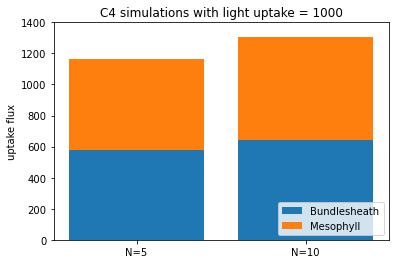

In [21]:
import matplotlib.pyplot as plt

plt.bar(['N=5','N=10'], [B_count.flux.sum(),B_count2.flux.sum()])
plt.bar(['N=5','N=10'], [M_count.flux.sum(), M_count2.flux.sum()], bottom = [B_count.flux.sum(),B_count2.flux.sum()])
plt.ylim([0,1400])
plt.ylabel('uptake flux')
plt.title('C4 simulations with light uptake = 1000')
plt.legend(labels=['Bundlesheath', 'Mesophyll'], loc='lower right')
plt.show()

In [ ]:
"""
Comparison of C3 and C4 model with varying nitrogen uptake
"""

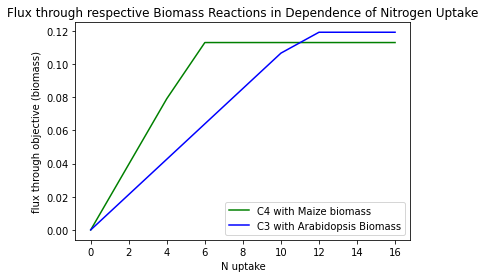

In [23]:
# C3 and C4 are compared with their respective biomass reactions (Arabidopsis - C3 and Maize - C4)
import matplotlib.pyplot as plt

c4_Nsim_y = []
c3_Nsim_y = []
Nsim_x = []
for i in range(0,18,2):
    c4_Nsim_y.append(c4_simulation(1000, i, c4_model, "value"))
    c3_Nsim_y.append(c3_simulation(1000, i, c3_model, "value"))
    Nsim_x.append(i)

plt.plot(Nsim_x, c4_Nsim_y, "g") # c4 in green
plt.plot(Nsim_x, c3_Nsim_y, "b") # c3 in blue
plt.xlabel("N uptake")
plt.ylabel("flux through objective (biomass)")
plt.title('Flux through respective Biomass Reactions in Dependence of Nitrogen Uptake')
plt.legend(["C4 with Maize biomass", "C3 with Arabidopsis Biomass"])
plt.show()

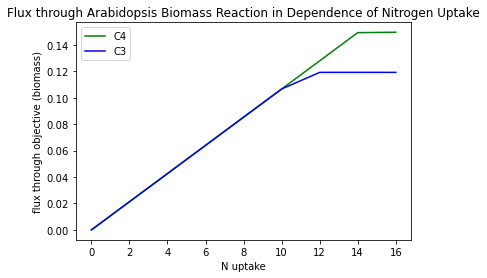

In [24]:
# the C3 and C4 model both have the Arabidopsis Biomass Reaction as their objective
import matplotlib.pyplot as plt

c4_Nsim_y = []
c3_Nsim_y = []
Nsim_x = []
for i in range(0,18,2):
    with c4_model:
        c4_model.objective ='[B]_Arabidopsis_biomass_tx'
        c4_Nsim_y.append(c4_simulation(1000, i, c4_model, "value"))
    c3_Nsim_y.append(c3_simulation(1000, i, c3_model, "value"))
    Nsim_x.append(i)

plt.plot(Nsim_x, c4_Nsim_y, "g") # c4 in green
plt.plot(Nsim_x, c3_Nsim_y, "b") # c3 in blue
plt.xlabel("N uptake")
plt.ylabel("flux through objective (biomass)")
plt.title('Flux through Arabidopsis Biomass Reaction in Dependence of Nitrogen Uptake')
plt.legend(["C4", "C3"])
plt.show()

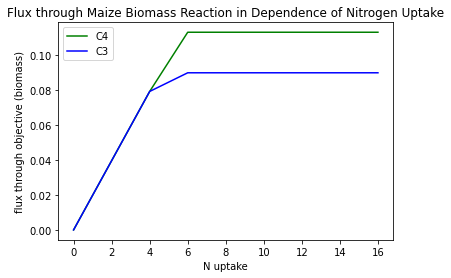

In [25]:
# the C3 and C4 model both have the Maize Biomass Reaction as their objective
import matplotlib.pyplot as plt

c4_Nsim_y = []
c3_Nsim_y = []
Nsim_x = []
for i in range(0,18,2):
    with c3_model:
        c3_model.objective = 'Maize_biomass_tx'
        c3_Nsim_y.append(c3_simulation(1000, i, c3_model, "value"))
    c4_Nsim_y.append(c4_simulation(1000, i, c4_model, "value"))
    Nsim_x.append(i)

plt.plot(Nsim_x, c4_Nsim_y, "g") # c4 in green
plt.plot(Nsim_x, c3_Nsim_y, "b") # c3 in blue
plt.xlabel("N uptake")
plt.ylabel("flux through objective (biomass)")
plt.title('Flux through Maize Biomass Reaction in Dependence of Nitrogen Uptake')
plt.legend(["C4", "C3"])
plt.show()

In [ ]:
"""
Comparison of C3 and C4 model with varying light uptake
"""

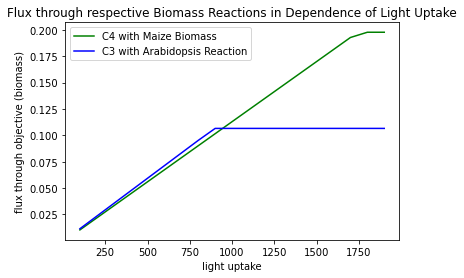

In [27]:
# C3 and C4 are compared with their respective biomass reactions (Arabidopsis - C3 and Maize - C4)
import matplotlib.pyplot as plt

c4_lightsim_y = []
c3_lightsim_y = []
lightsim_x = []
for i in range(100,2000,100):
    c4_lightsim_y.append(c4_simulation(i, 10, c4_model, "value"))
    c3_lightsim_y.append(c3_simulation(i, 10, c3_model, "value"))
    lightsim_x.append(i)

plt.plot(lightsim_x, c4_lightsim_y, 'g') # c4 in green
plt.plot(lightsim_x, c3_lightsim_y, 'b') # c3 in blue
plt.xlabel("light uptake")
plt.ylabel("flux through objective (biomass)")
plt.title('Flux through respective Biomass Reactions in Dependence of Light Uptake')
plt.legend(["C4 with Maize Biomass", "C3 with Arabidopsis Reaction"])
plt.show()

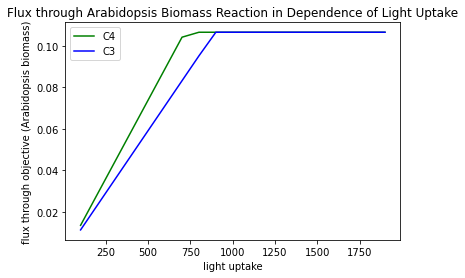

In [28]:
# the C3 and C4 model both have the Arabidopsis Biomass Reaction as their objective
import matplotlib.pyplot as plt

c4_lightsim_y = []
c3_lightsim_y = []
lightsim_x = []
for i in range(100,2000,100):
    with c4_model:
        c4_model.objective ='[B]_Arabidopsis_biomass_tx'
        c4_lightsim_y.append(c4_simulation(i, 10, c4_model, "value"))
    c3_lightsim_y.append(c3_simulation(i, 10, c3_model, "value"))
    lightsim_x.append(i)

plt.plot(lightsim_x, c4_lightsim_y, 'g') # c4 in green
plt.plot(lightsim_x, c3_lightsim_y, 'b') # c3 in blue
plt.xlabel("light uptake")
plt.ylabel("flux through objective (Arabidopsis biomass)")
plt.title('Flux through Arabidopsis Biomass Reaction in Dependence of Light Uptake')
plt.legend(["C4", "C3"])
plt.show()

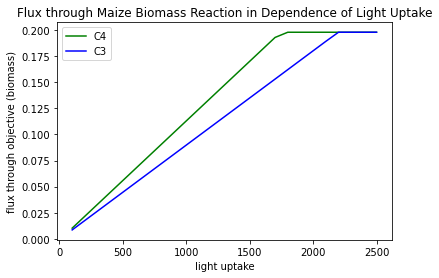

In [29]:
# the C3 and C4 model both have the Maize Biomass Reaction as their objective
import matplotlib.pyplot as plt

c4_lightsim_y = []
c3_lightsim_y = []
lightsim_x = []
for i in range(100,2600,100):
    with c3_model:
        c3_model.objective = 'Maize_biomass_tx'
        c3_lightsim_y.append(c3_simulation(i, 10, c3_model, "value"))
    c4_lightsim_y.append(c4_simulation(i, 10, c4_model, "value"))
    lightsim_x.append(i)

plt.plot(lightsim_x, c4_lightsim_y, 'g') # c4 in green
plt.plot(lightsim_x, c3_lightsim_y, 'b') # c3 in blue
plt.xlabel("light uptake")
plt.ylabel("flux through objective (biomass)")
plt.title('Flux through Maize Biomass Reaction in Dependence of Light Uptake')
plt.legend(["C4", "C3"])
plt.show()

In [30]:
c3_model.reactions.get_by_id("RXN_961_p")

Reaction identifier,RXN_961_p
Name,RXN-961:NIL
Memory address,0x0277eb21ec48
Stoichiometry,D_RIBULOSE_15_P2_p + OXYGEN_MOLECULE_p --> CPD_67_p + G3P_p + 2.0 PROTON_p D-RIBULOSE-15-P2 + OXYGEN-MOLECULE --> CPD-67 + G3P + 2.0 PROTON
GPR,
Lower bound,0.0
Upper bound,9999999.0


In [31]:
c3_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p")

Reaction identifier,RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p
Name,RIBULOSE-BISPHOSPHATE-CARBOXYLASE-RXN:Ribulose-bisphosphate carboxylase
Memory address,0x0277eaf5a948
Stoichiometry,CARBON_DIOXIDE_p + D_RIBULOSE_15_P2_p + WATER_p --> 2.0 G3P_p + 2.0 PROTON_p CARBON-DIOXIDE + D-RIBULOSE-15-P2 + WATER --> 2.0 G3P + 2.0 PROTON
GPR,
Lower bound,0.0
Upper bound,9999999.0


In [32]:
c3_model.reactions.get_by_id("GPH_RXN_p")

Reaction identifier,GPH_RXN_p
Name,GPH-RXN:Phosphoglycolate phosphatase
Memory address,0x0277eb1d2948
Stoichiometry,CPD_67_p + WATER_p --> GLYCOLLATE_p + Pi_p CPD-67 + WATER --> GLYCOLLATE + Pi[p]
GPR,
Lower bound,0.0
Upper bound,9999999.0


In [33]:
c4_model.reactions.query("Phloem")

[<Reaction [M]_Phloem_output_tx at 0x277ebcd7308>,
 <Reaction [B]_Phloem_output_tx at 0x277ebcd73c8>]

In [34]:
"""
Simulation if C3 model is not able to do Photorespiration
-> reaction to convert 2PG into Glycolate (starting point PR) is knocked out
"""
with c3_model:
    # set_bounds('GPH_RXN_p', (0,0), c3_model) # this is one way to do it, upper and lower bound to zero
    c3_model.reactions.GPH_RXN_p.knock_out() # this is a second way, with knock out function
    print(c3_simulation(1000, 10 , c3_model, ''))

Objective
1.0 Arabidopsis_biomass_tx = 4.409674033622847e-17

Uptake
------
Metabolite      Reaction  Flux  C-Number C-Flux
  Photon_e     Photon_tx 5.887         0  0.00%
  PROTON_c unlProtHYPO_c 1.164         0  0.00%

Secretion
---------
Empty DataFrame
Columns: [Metabolite, Reaction, Flux, C-Number, C-Flux]
Index: []

